<a href="https://www.kaggle.com/code/yigitgun/vision-transformer-model-using-pytorch?scriptVersionId=124314967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cats-in-the-wild-image-classification/WILDCATS.CSV
/kaggle/input/cats-in-the-wild-image-classification/EfficientNetB0-10-(224 X 224)-100.00.h5
/kaggle/input/cats-in-the-wild-image-classification/MobileNetV3 small-10-(224 X 224)-95.96.h5
/kaggle/input/cats-in-the-wild-image-classification/valid/CHEETAH/5.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/CHEETAH/1.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/CHEETAH/4.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/CHEETAH/3.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/CHEETAH/2.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/LIONS/5.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/LIONS/1.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/LIONS/4.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/LIONS/3.jpg
/kaggle/input/cats-in-the-wild-image-classification/valid/LIONS/2.jpg
/kaggle/input/cats-in-the-wild-image-cl

In [2]:
!pip install timm

In [3]:
# Necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import ConcatDataset
import time
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import copy
import glob
import timm
from torch.utils.tensorboard import SummaryWriter

In [4]:
df = pd.read_csv("/kaggle/input/cats-in-the-wild-image-classification/WILDCATS.CSV")

In [5]:
df.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


JAGUAR             248
TIGER              247
AFRICAN LEOPARD    246
CARACAL            246
PUMA               246
CHEETAH            245
OCELOT             243
SNOW LEOPARD       241
CLOUDED LEOPARD    239
LIONS              238
Name: labels, dtype: int64
2439


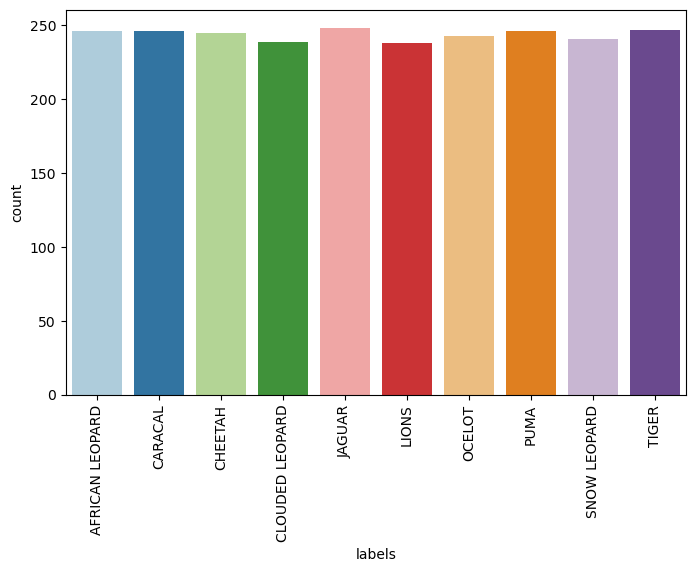

In [6]:
# Data Visualization

print(df['labels'].value_counts())
print(df['labels'].value_counts().sum())
plt.figure(figsize=(8,5))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.countplot(x='labels', data=df, palette='Paired')
plt.show()

In [7]:
# Data augmentation and data definitions

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.GaussianBlur(kernel_size=(5,5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
}

data_dir = '/kaggle/input/cats-in-the-wild-image-classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid','test']}

# Split the 'train' dataset into train and validation sets

train_data, val_data = train_test_split(image_datasets['train'], test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)


# Create the dataloaders for training, validation, and testing
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4),
               'valid': torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4),
               'test' : torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)
              }

dataset_sizes = {'train': len(train_data), 'valid': len(val_data), 'test': len(test_data)}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
print(class_names)

['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


In [9]:
print("Size of training data is:")
print(len(train_data))
print('-' * 25)
print("Size of validation data is:")
print(len(val_data))
print('-' * 25)
print("Size of test data is:")
print(len(test_data))

Size of training data is:
1871
-------------------------
Size of validation data is:
234
-------------------------
Size of test data is:
234


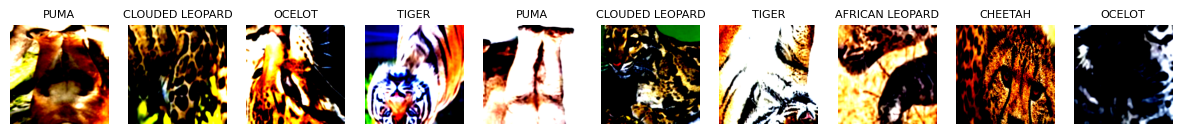

In [10]:
# Few images to visualize

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off') # remove axis ticks and labels


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Get class labels
label_names = [class_names[x] for x in classes]

# Display images with labels in a row
fig, axs = plt.subplots(1, 10, figsize=(15, 10))

for i in range(10):
    axs[i].imshow(inputs[i].permute(1, 2, 0))
    axs[i].set_title(label_names[i],fontsize=8)
    axs[i].axis('off')
    
plt.show()

In [11]:
# Training
from torch.utils.tensorboard import SummaryWriter

def train_model(model, criterion, optimizer, scheduler, num_epochs=5, log_dir='./logs'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    # Create a TensorBoard summary writer
    writer = SummaryWriter(log_dir)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Log the loss and accuracy to TensorBoard
            writer.add_scalar(f'{phase}/loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}/accuracy', epoch_acc, epoch)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Close the TensorBoard writer
    writer.close()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [12]:
# Visualizing predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
# Load pre-trained Vision Transformer model
model_ft = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze all layers in the model
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the classifier with a new one that is trainable
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),   # To prevent training data to overfit 
    nn.Linear(512, len(class_names))
)

# Move the model to the device (e.g. GPU)
model_ft = model_ft.to(device)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer (unfreeze the classifier's parameters)
optimizer_ft = optim.Adam(model_ft.head.parameters(), lr=0.001)

# Set up learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.25)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


train Loss: 0.6921 Acc: 0.7745


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


valid Loss: 0.4184 Acc: 0.8761

Epoch 1/11
----------


100%|██████████| 59/59 [00:21<00:00,  2.69it/s]


train Loss: 0.3166 Acc: 0.8974


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


valid Loss: 0.3587 Acc: 0.8803

Epoch 2/11
----------


100%|██████████| 59/59 [00:22<00:00,  2.59it/s]


train Loss: 0.2422 Acc: 0.9220


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


valid Loss: 0.3615 Acc: 0.8675

Epoch 3/11
----------


100%|██████████| 59/59 [00:23<00:00,  2.46it/s]


train Loss: 0.1905 Acc: 0.9369


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


valid Loss: 0.4638 Acc: 0.8632

Epoch 4/11
----------


100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


train Loss: 0.1889 Acc: 0.9311


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


valid Loss: 0.3728 Acc: 0.8761

Epoch 5/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


train Loss: 0.1095 Acc: 0.9647


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


valid Loss: 0.3938 Acc: 0.8590

Epoch 6/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


train Loss: 0.0856 Acc: 0.9776


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


valid Loss: 0.4285 Acc: 0.8590

Epoch 7/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


train Loss: 0.0799 Acc: 0.9754


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


valid Loss: 0.3970 Acc: 0.8590

Epoch 8/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


train Loss: 0.0656 Acc: 0.9834


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


valid Loss: 0.3852 Acc: 0.8632

Epoch 9/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


train Loss: 0.0639 Acc: 0.9824


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


valid Loss: 0.3914 Acc: 0.8675

Epoch 10/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


train Loss: 0.0514 Acc: 0.9856


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


valid Loss: 0.3985 Acc: 0.8632

Epoch 11/11
----------


100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


train Loss: 0.0515 Acc: 0.9861


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

valid Loss: 0.3964 Acc: 0.8590

Training complete in 5m 43s
Best val Acc: 0.880342


In [15]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir logs

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


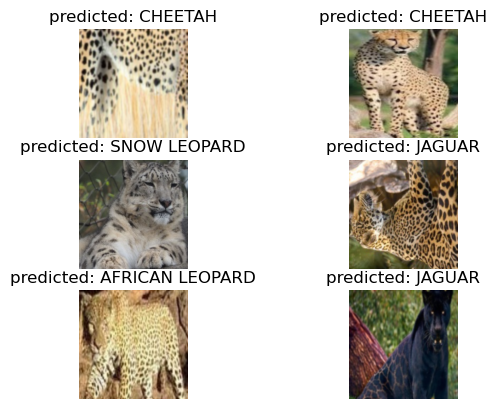

In [17]:
# Few Predictions
visualize_model(model_ft)

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images,labels in dataloaders['test']:
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 88 %


In [19]:
class_names = ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']

In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for images,labels in dataloaders['test']:
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: AFRICAN LEOPARD is 90.9 %
Accuracy for class: CARACAL is 83.3 %
Accuracy for class: CHEETAH is 87.0 %
Accuracy for class: CLOUDED LEOPARD is 86.4 %
Accuracy for class: JAGUAR is 66.7 %
Accuracy for class: LIONS is 88.0 %
Accuracy for class: OCELOT is 88.5 %
Accuracy for class: PUMA  is 95.2 %
Accuracy for class: SNOW LEOPARD is 95.7 %
Accuracy for class: TIGER is 100.0 %
